In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import load as tload
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from src.models.LNSequenceModule import SequenceModule


In [2]:
def encode_sequence(sequence, vocabulary_mapping):
    return [vocabulary_mapping[gene_name] for gene_name in sequence]

def encode_wo_nohit_sequence(sequence, vocabulary_mapping):
    return [vocabulary_mapping[gene_name] for gene_name in sequence if gene_name != "no_hit"]

def count_encode(samples, vocab_size):
    features = np.zeros((len(samples), vocab_size), dtype=int)
    for i, sample in enumerate(samples):
        for gene_code in sample:
            if not gene_code-1 < vocab_size:
                print("ERROR: ", gene_code)
            else:
                features[i, gene_code-1] += 1
    
    return features

In [3]:
root = Path("/Users/madsniels/Documents/_DTU/speciale/cpr/code/psim")
dataset_root = root / "data/processed/10_datasets/"
version = "dataset_v02"
dataset = dataset_root / version
checkpoint = root / "models/transformer/alldb_v02_small_iak7l6eg.ckpt"
# Output
output_root = root / "data/visualization/performance/linear/"
outputfn = output_root / "logistic_pfamdb_v02.txt"

mo = SequenceModule.load_from_checkpoint(checkpoint_path=checkpoint, map_location="cpu")
vocab_map = mo.vocab_map
print(vocab_map['<PAD>'])
print(vocab_map['no_hit'])
print(len(vocab_map))
del vocab_map['<PAD>']
del vocab_map['no_hit']
print(len(vocab_map))
print(list(vocab_map.keys())[0], list(vocab_map.values())[0])
print(list(vocab_map.keys())[-1], list(vocab_map.values())[-1])

0
200
201
199
PF00038.24 1
PF20441.1 199


In [4]:
data_splits = tload(dataset / "strings" / "allDB" / "dataset.pt", map_location="cpu")
print("ORIGINAL: ")
print(data_splits['train']['sequences'][0][:10])
X_train = [encode_wo_nohit_sequence(string, vocab_map) for string in data_splits['train']['sequences']]
print("INTEGER ENCODING: ")
print(X_train[0][:10])
X_train = count_encode(X_train, len(vocab_map))
print("COUNT ENCODING SHAPE: ")
print(X_train.shape)
y_train = data_splits['train']['labels'].numpy()
scaler = StandardScaler()

# Scale
X_train = scaler.fit_transform(X_train)
print("SCALED: ")
print(X_train.shape)
print(X_train[0][:10])



ORIGINAL: 
['no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit', 'no_hit']
INTEGER ENCODING: 
[31, 7]
COUNT ENCODING SHAPE: 
(5674, 199)
SCALED: 
(5674, 199)
[-0.14581372 -0.36159485 -0.12983696 -0.16576217 -0.11156363 -0.29493943
  3.28205109 -0.12577415 -0.26213864 -0.15192004]


In [5]:
model = LogisticRegression(penalty='l1', max_iter=5000, solver='saga', C=1, random_state=1, n_jobs=4)
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000, n_jobs=4, penalty='l1', random_state=1,
                   solver='saga')

In [6]:
X_test = [encode_wo_nohit_sequence(string, vocab_map) for string in data_splits['test']['sequences']]
X_test = count_encode(X_test, len(vocab_map))
X_test = scaler.transform(X_test)
y_test = data_splits['test']['labels'].numpy()
y_pred = model.predict(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC Score: {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
print(cm)


Accuracy: 0.9774647887323944
Precision: 0.9497206703910615
Recall: 0.96045197740113
F1 Score: 0.9550561797752809
ROC-AUC Score: 0.9974772368323422
[[524   9]
 [  7 170]]


In [5]:
feature_names = list(vocab_map.keys())
model_list = []
features_list = []
for c_value in [1,0.5,0.1,0.05,0.01,0.005]:
    model = LogisticRegression(penalty='l1', max_iter=5000, C=c_value, solver='saga', random_state=1,)
    model.fit(X_train, y_train)
    X_test = [encode_wo_nohit_sequence(string, vocab_map) for string in data_splits['test']['sequences']]
    X_test = count_encode(X_test, len(vocab_map))
    X_test = scaler.transform(X_test)
    y_test = data_splits['test']['labels'].numpy()
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    coefficients = model.coef_[0]
    pos_coefficients = coefficients[coefficients > 0]
    neg_coefficients = coefficients[coefficients < 0]
    print(f'C: {c_value}', f'Pos coeff: {len(pos_coefficients)}', f'Neg coeff: {len(neg_coefficients)}')
    print(f'Precision: {precision}', f'Recall: {recall}', f'F1 Score: {f1}', f'ROC-AUC Score: {roc_auc}')
    final_coeff = []
    final_features = []
    for n, coeff in enumerate(coefficients):
        if coeff > 0:
            final_coeff.append(coeff)
            final_features.append(feature_names[n])
        elif coeff < 0:
            final_coeff.append(coeff)
            final_features.append(feature_names[n])
    features_list.append(zip(final_features.copy(), final_coeff.copy()))
    model_list.append(model)


C: 1 Pos coeff: 444 Neg coeff: 229
Precision: 0.9883040935672515 Recall: 0.9548022598870056 F1 Score: 0.9712643678160918 ROC-AUC Score: 0.995749462057854
C: 0.5 Pos coeff: 330 Neg coeff: 151
Precision: 0.9883720930232558 Recall: 0.96045197740113 F1 Score: 0.9742120343839542 ROC-AUC Score: 0.9930518014436989
C: 0.1 Pos coeff: 217 Neg coeff: 60
Precision: 0.9941520467836257 Recall: 0.96045197740113 F1 Score: 0.9770114942528735 ROC-AUC Score: 0.9929670026817607
C: 0.05 Pos coeff: 169 Neg coeff: 28
Precision: 0.9881656804733728 Recall: 0.943502824858757 F1 Score: 0.9653179190751445 ROC-AUC Score: 0.9929564028365185
C: 0.01 Pos coeff: 59 Neg coeff: 0
Precision: 0.9936708860759493 Recall: 0.8870056497175142 F1 Score: 0.9373134328358209 ROC-AUC Score: 0.9902375425318791
C: 0.005 Pos coeff: 33 Neg coeff: 0
Precision: 1.0 Recall: 0.7966101694915254 F1 Score: 0.8867924528301886 ROC-AUC Score: 0.9730869929299033


In [74]:
from Bio import SeqIO
out_f = Path("/Users/madsniels/Documents/_DTU/speciale/cpr/data/visualization/performance/linear_feature_selection/feature_representatives/")
out_fasta = out_f / f"c_{c_value}_sequences.faa"
out_fasta.mkdir(parents=True, exist_ok=True)
in_fasta = Path("/Users/madsniels/Documents/_DTU/speciale/cpr/code/psim/data/processed/10_datasets/v02/attachings_allDB/proteins.faa").absolute()

coefficients = model.coef_[0]
feature_names = list(vocab_map.keys())
feature_importance = dict(zip(feature_names, coefficients))
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

#with open(out_fasta, 'w') as fout:
for n, (feature, coef) in enumerate(sorted_features):
    if coef == 0:
        continue
    else:
        for seq_record in SeqIO.parse(in_fasta, "fasta"):
            if seq_record.id.replace('|','_') == feature:
                print(seq_record.id)
                print(seq_record.seq[0:10])
                #SeqIO.write(seq_record, fout, "fasta")
                break
        else:
            print("ERROR: ", feature)



PS_R4849|22
MSQSSAYGYN


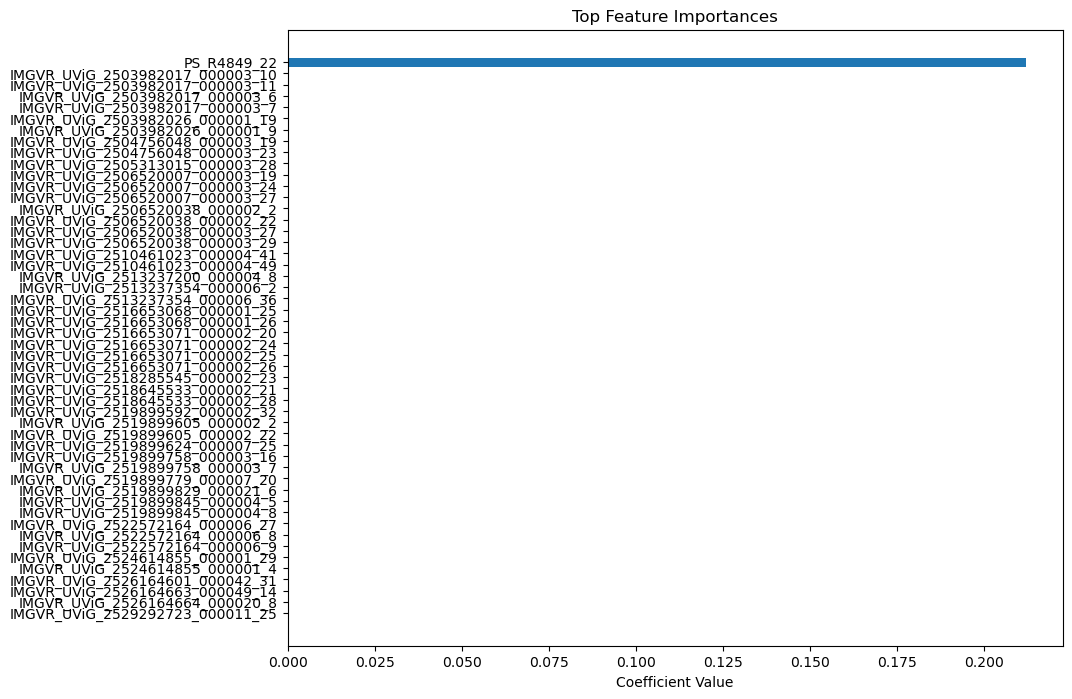

In [55]:
coefficients = model.coef_[0]
feature_names = list(vocab_map.keys())
feature_importance = dict(zip(feature_names, coefficients))
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Select top N features for visualization
top_n = 50
top_features, top_scores = zip(*sorted_features[:top_n])

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_scores, align='center')
plt.yticks(range(top_n), top_features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('Coefficient Value')
plt.title('Top Feature Importances')
plt.show()

In [59]:
pos_coeff = 0
neg_coeff = 0
final_coeff = []
final_features = []
for n, coeff in enumerate(coefficients):
    if coeff > 0:
        final_coeff.append(coeff)
        final_features.append(feature_names[n])
        pos_coeff += 1
    elif coeff < 0:
        final_coeff.append(coeff)
        final_features.append(feature_names[n])
        neg_coeff += 1

print(f"Positive coefficients: {pos_coeff}")
print(f"Negative coefficients: {neg_coeff}")
print(f"Total coefficients: {len(coefficients)}")


Positive coefficients: 1
Negative coefficients: 0
Total coefficients: 6175


In [52]:
for n, (feature, coeff) in enumerate(sorted(zip(final_features, final_coeff), key=lambda x: abs(x[1]), reverse=True)):
    print(f"{n+1}. {feature}: {coeff}")

1. PS_R4849_22: 0.21210002181466553


In [30]:

for feat, coeffi in features_list[]:
    print(f"{feat}: {coeffi}")

IndexError: list index out of range

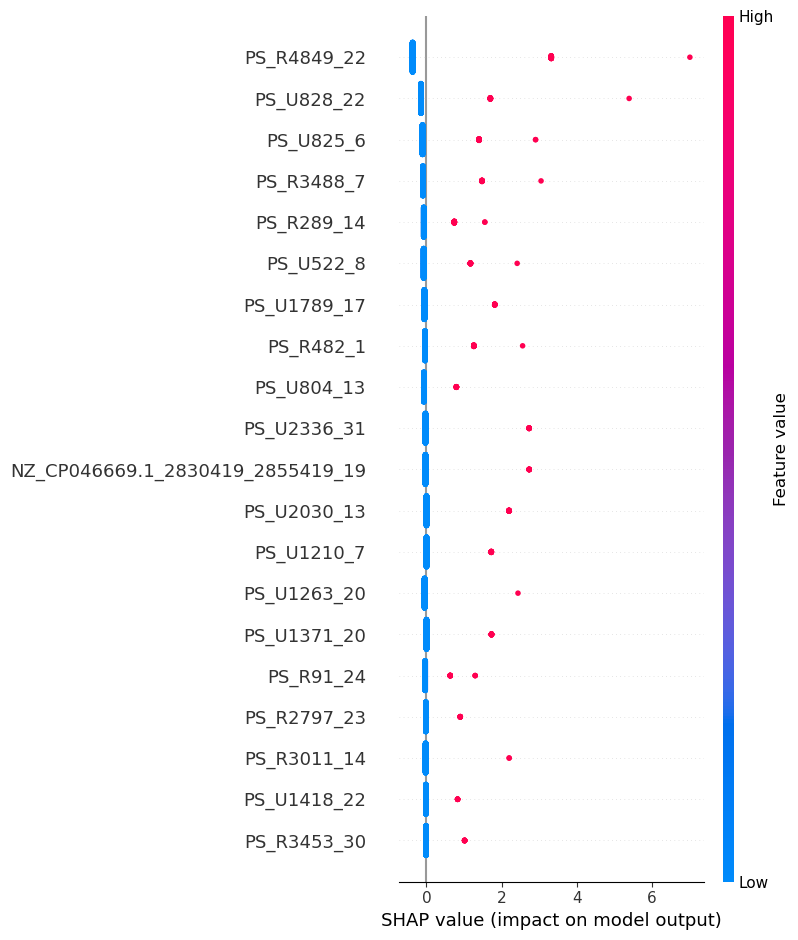

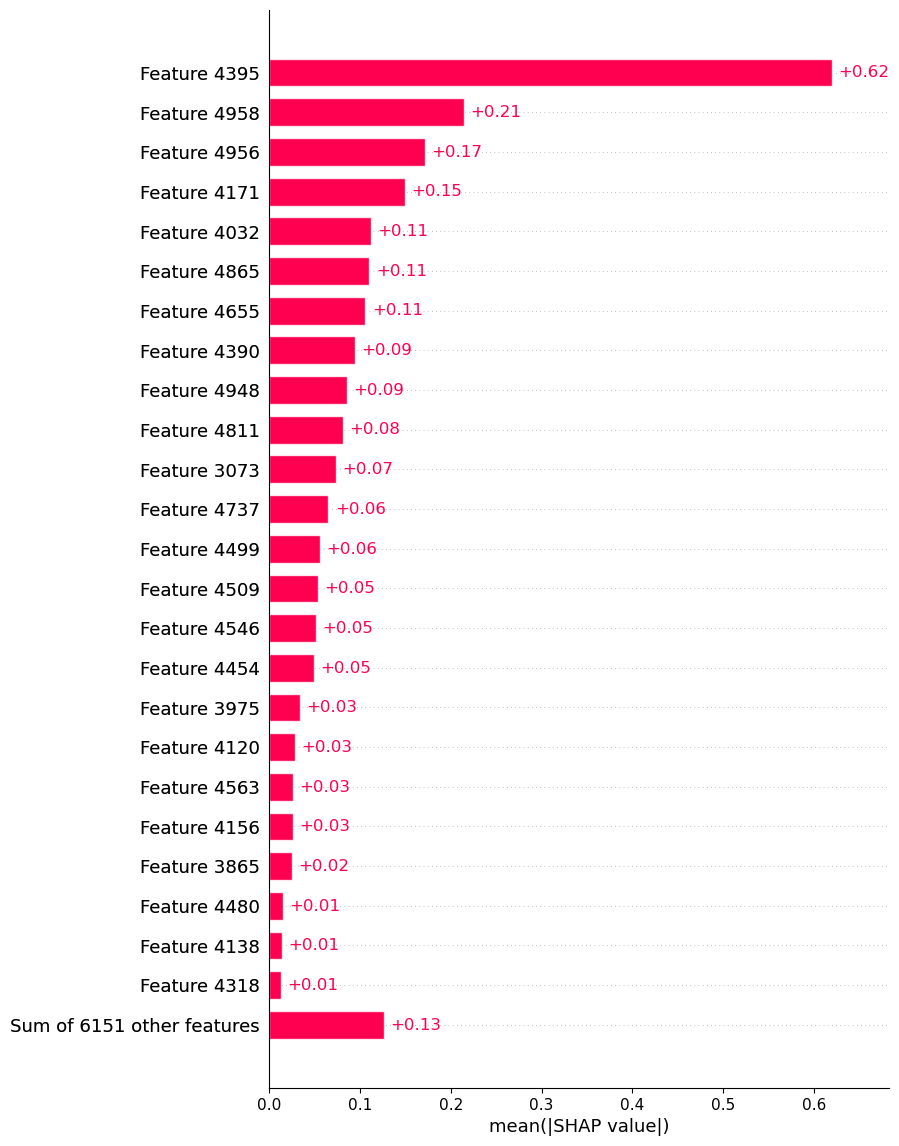

In [20]:
explainer = shap.Explainer(model_list[-2], X_train)
shap_values = explainer(X_test)
feature_names = list(vocab_map.keys())
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

shap.plots.bar(shap_values, max_display=25)

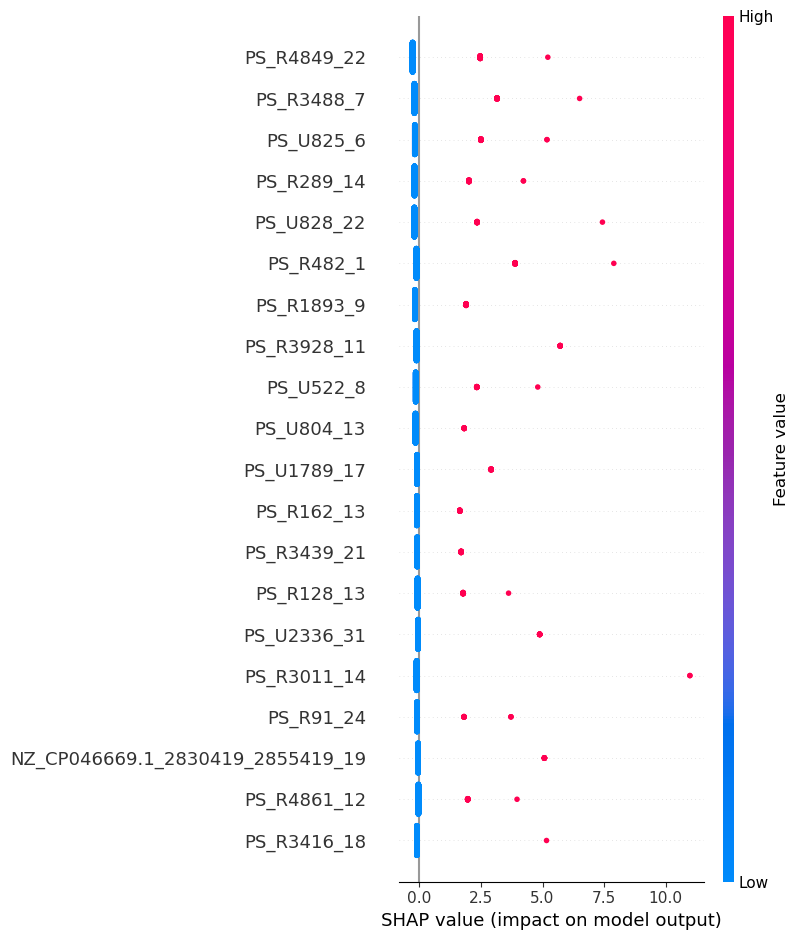

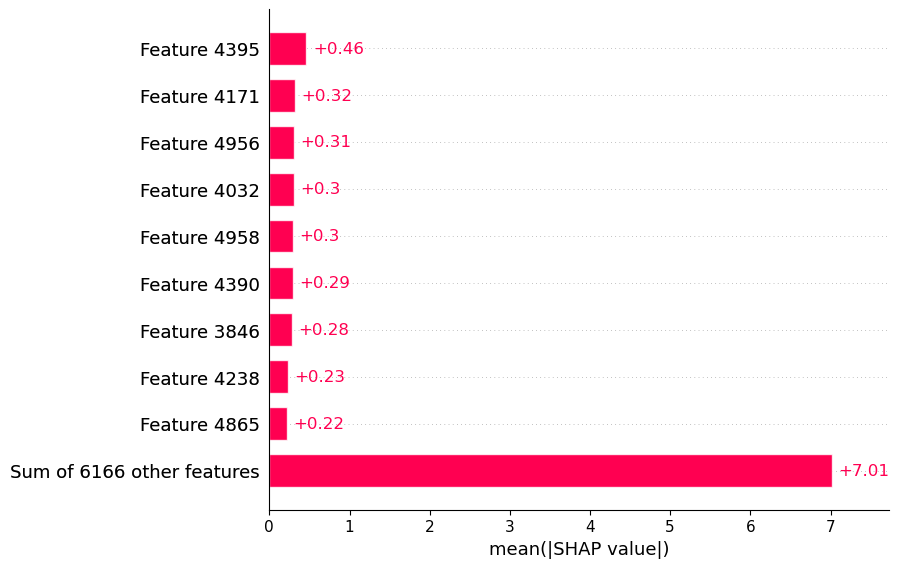

In [148]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
feature_names = list(vocab_map.keys())
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

shap.plots.bar(shap_values)

In [149]:
feature_names[4395]

'PS_R4849_22'

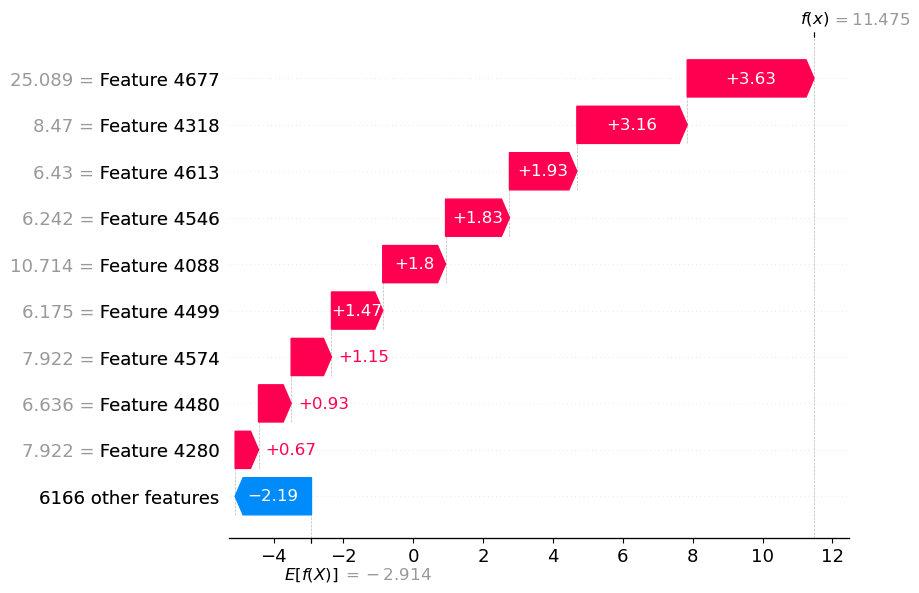

In [153]:
shap.plots.waterfall(shap_values[1], max_display=10)

In [120]:
split = 'val'
df = pd.read_csv(dataset / f"{split}.tsv", sep="\t", header=0, names=["id", "type", "label"])
sequences = data_splits[split]['sequences']
test_ids = df["id"].values.tolist()
test_labels = df["label"].values.tolist()
test_types = df["type"].values.tolist()

In [121]:
for sequence in data_splits['train']['sequences']:
    for prot in sequence:
        genome = prot.rsplit('_', 1)[0]
        if genome in test_ids:
            print("err")

In [117]:
print(test_ids)

['NZ_CP056168.1_2351902_2376902', 'PS_U1968', 'NZ_LT992467.1_2354379_2379379', 'IMGVR_UViG_2925914267_000003', 'SSRR5279275Ccontig255', 'SSRR4305071Ccontig126', 'PS_R3987', 'PS_R3985', 'IMGVR_UViG_2907820058_000002', 'NZ_CP023174.1_3304236_3329236', 'PS_U13', 'NZ_LR778147.1_1847121_1872121', 'IMGVR_UViG_2847461936_000001', 'SERR414243Ccontig855', 'PS_U1438', 'SSRR5056660Ccontig484', 'SERR1190814Ccontig1170', 'SERR525915Ccontig424', 'SERR1913030Ccontig22', 'PS_U1833', 'IMGVR_UViG_2645727744_000004', 'IMGVR_UViG_2645727826_000004', 'PS_R1781', 'SERR414442Ccontig242', 'NZ_CP060083.1_5170305_5195305', 'PS_R4004', 'SSRR3160441Ccontig475', 'NZ_CP015574.1_928449_953449', 'IMGVR_UViG_2718218359_000001', 'PS_R1137', 'NZ_CP041845.1_3410808_3435808', 'IMGVR_UViG_2924309928_000001', 'IMGVR_UViG_2926642366_000001', 'SSRR4408028Ccontig129', 'PS_U2103', 'PS_U826', 'IMGVR_UViG_2806310932_000001', 'PS_R1850', 'SSRR3132387Ccontig24', 'SERR1620340Ccontig217', 'SERR414343Ccontig1098', 'IMGVR_UViG_28141230